<a href="https://colab.research.google.com/github/xunzxe/first-repository/blob/master/Main_quest/Quest03/03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 폐렴 판별 모델
### 모델 훈련 단계에서 계속 error가 떠서 원인을 계속 찾아봐야겠다.

## STEP 1. Set-up
___

In [ ]:
# 패키지 import

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
TRAIN_PATH = '/content/drive/MyDrive/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = '/content/drive/MyDrive/data/val/*/*'
TEST_PATH = '/content/drive/MyDrive/data/test/*/*'

# 아래 두 변수 조절
BATCH_SIZE = 16
EPOCHS = 10

## STEP 2. 데이터 가져오기
___

In [ ]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [ ]:
# train, test, val size 수정

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [ ]:
# 정상 이미지와 폐렴 이미지 구분

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal image path
/content/drive/MyDrive/data/train/NORMAL/NORMAL2-IM-1163-0001.jpeg
Pneumonia image path
/content/drive/MyDrive/data/train/PNEUMONIA/person1081_bacteria_3021.jpeg
Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [ ]:
# Train 데이터셋, validation 데이터셋

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [ ]:
# 라벨 데이터 만들어주는 함수

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [ ]:
# 이미지 데이터 전처리 함수

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [ ]:
# train 데이터 셋, validation 데이터 셋

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
# 이미지 리사이즈, 라벨여부 확인

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [ ]:
# test 데이터 셋

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [ ]:
# 데이터 변환

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 무작위로 균일하게 선택
    ds = ds.repeat() # 데이터셋 반복 사용
    ds = ds.batch(BATCH_SIZE) # 배치 사이즈로 데이터 분류
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습 데이터 나눠서 읽어 리소스의 유휴 상태 줄임
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [ ]:
# data augmentation

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


## STEP 3. 데이터 시각화
---

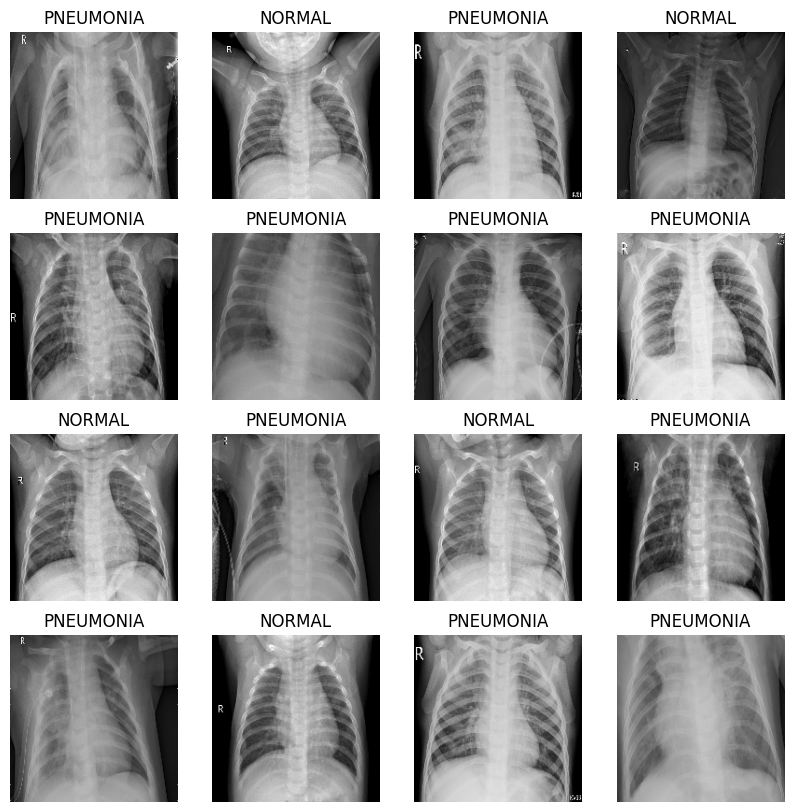

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## STEP 4. CNN 모델링
---

In [ ]:
# Convolution block
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [ ]:
# Dense Block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),  # variance shift 억제
        tf.keras.layers.Dropout(dropout_rate)  # variance shift 유발
    ])

    return block

In [ ]:
# model 구조
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [ ]:
def identity_block(X, filters, kernel_size):
    X_shortcut = X

    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)

    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)

    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)

    return X


def convolutional_block(X, filters, kernel_size):
    X_shortcut = X

    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)

    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)

    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X_shortcut = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)

    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)

    return X

def ResNet(input_shape = (32, 32, 3), classes = 10):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input

    X = tf.keras.layers.Conv2D(64, (3,3), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)

    X = convolutional_block(X, 64, (3,3)) #use conv block (?)
    X = identity_block(X, 64, (3,3))
    X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)

    X = convolutional_block(X, 128, (3,3)) #64->128, use conv block
    X = identity_block(X, 128, (3,3))
    X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)

    X = convolutional_block(X, 256, (3,3)) #128->256, use conv block
    X = identity_block(X, 256, (3,3))
    X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)

    X = convolutional_block(X, 512, (3,3)) #256->512, use conv block
    X = identity_block(X, 512, (3,3))
    X = identity_block(X, 512, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)

    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(10, activation = 'softmax')(X) # ouput layer (10 class)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "ResNet")

    return model

## STEP 5. 데이터 imbalance 처리
---

In [ ]:
# weight balancing : 클래스 불균형 처리

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  # Normal
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0 # Pneumonia

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## STEP 6. 모델 훈련
---

In [ ]:
#  model training

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight, # 클래스 레이블마다 가중치 부여
    )

TypeError: Value passed to parameter 'x' has DataType bool not in list of allowed values: bfloat16, float16, float32, float64, int8, int16, int32, int64, complex64, complex128